Predicting probability of churn 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Rule-based algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_excel('data.xlsx')

,CustomerID,Name,Age,Email,EmploymentStatus,HousingStatus,ActiveMember,Country,EstimatedSalary,Balance,...,CustomerEngagementScore,TechSupportTicketCount,NumberOfAppCrashes,NavigationDifficulty,UserFrustration,CustomerSatisfactionSurvey,CustomerServiceCalls,NPS,Churn,Persona
0,15634602,Wyatt Miller,27,wyatt.miller47@gmail.com,0,1,1,Singapore,56424,85123.46,...,10,0,0,0,0,3,1,9,0,Opportunistic
1,15634603,Kathleen Coleman,27,kathleen.coleman79@gmail.com,0,1,1,Singapore,70079,51061.66,...,2,0,0,0,0,3,4,10,0,General
2,15634604,Mrs. Suzanne Torres MD,48,mrs..md62@gmail.com,1,1,1,Singapore,87211,86096.84,...,4,1,2,6,1,9,2,2,1,TechDifficulties
3,15634605,Christian Hoffman,64,christian.hoffman3@gmail.com,1,0,1,Singapore,79491,118453.65,...,9,0,0,0,0,8,2,7,0,Loyal
4,15634606,Marcus Henson,34,marcus.henson49@gmail.com,0,0,1,Singapore,73618,73389.26,...,10,2,2,6,1,10,1,6,0,TechDifficulties


In [4]:
X_2 = df.drop(columns=['CustomerID', 'Name', 'Email', 'Churn', 'Persona'])  # Also drop Persona
y_2 = df['Churn']  # Target variable for churn
# Continue with the numeric and categorical columns identification
numeric_columns = X_2.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_2.select_dtypes(include=['object']).columns.tolist()
print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

Numeric columns: ['Age', 'EmploymentStatus', 'HousingStatus', 'ActiveMember', 'EstimatedSalary', 'Balance', 'ProductsNumber', 'DebitCard', 'SavingsAccount', 'FlexiLoan', 'Tenure', 'DaysSinceLastTransaction', 'CustomerEngagementScore', 'TechSupportTicketCount', 'NumberOfAppCrashes', 'NavigationDifficulty', 'UserFrustration', 'CustomerSatisfactionSurvey', 'CustomerServiceCalls', 'NPS']
Categorical columns: ['Country', 'Gender']


In [5]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a column transformer to apply the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
        ])

In [16]:
from sklearn.linear_model import LogisticRegression
random_seed = 42

# Initialize logistic regression with a probability output
log_reg = LogisticRegression(random_state=random_seed)
# Split the data first before any processing
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


# Apply SMOTE to the training data after preprocessing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print("Shape of X after SMOTE:", X_train_resampled.shape)
print("Shape of y after SMOTE:", y_train_resampled.shape)

# Train the model on the resampled data
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
y_pred_prob = log_reg.predict_proba(X_test_preprocessed)[:, 1]  # Get the probability of positive class (churn)

# Predict probabilities on the test set
print("Sample of predicted probabilities:", y_pred_prob[:10])

Shape of X after SMOTE: (11034, 24)
Shape of y after SMOTE: (11034,)
Sample of predicted probabilities: [1.         0.00275477 1.         0.00435149 0.09207929 0.04381066
 1.         0.00108866 0.03204526 0.00132775]


ROC AUC score: 0.9999953773845472
Log loss: 0.018820977084523953


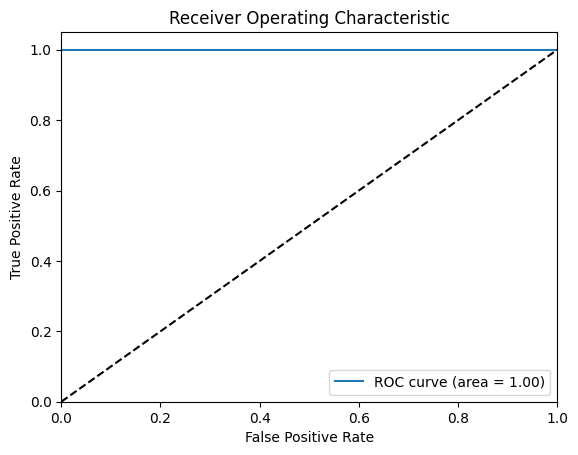

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
# Predict probabilities on the preprocessed test set
y_pred_prob = log_reg.predict_proba(X_test_preprocessed)[:, 1]

# Calculate the ROC AUC score
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score:", roc_auc)

# Calculate log loss
log_loss = metrics.log_loss(y_test, y_pred_prob)
print("Log loss:", log_loss)

# Plot the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
from sklearn.metrics import average_precision_score, log_loss

# For Precision-Recall AUC, we need to calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_prob)
print(f'Average Precision-Recall Score: {average_precision}')

# For Log Loss, we can directly use the probabilities and true labels
logloss_score = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {logloss_score}')

Average Precision-Recall Score: 0.9999900798817523
Log Loss: 0.018820977084523953


In [20]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create a new pipeline that includes preprocessing, SMOTE, PCA, and logistic regression
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.95)),  # Configured to retain 95% of the variance
    ('logisticregression', LogisticRegression(random_state=42))
])

# Define a hyperparameter grid to search
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'pca__n_components': [0.85, 0.90, 0.95]  # Experiment with different levels of variance to keep
}

# Set up GridSearchCV
search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data only
search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", search.best_params_)
print("Best ROC AUC score:", search.best_score_)

# After fitting, use the best model to predict probabilities on the test set
best_model = search.best_estimator_
predicted_probabilities = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'pca__n_components': 0.95}
Best ROC AUC score: 1.0
Sample of predicted probabilities: [1.00000000e+00 2.55466349e-07 1.00000000e+00 7.34268666e-07
 4.98355827e-03]


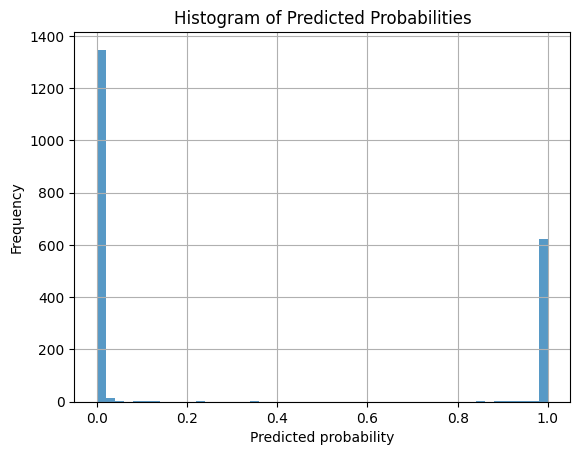

In [23]:
import matplotlib.pyplot as plt

# Plot a histogram of the predicted probabilities
plt.hist(predicted_probabilities, bins=50, alpha=0.75)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()